# Overview
FitsnBits is a stock market prediction models that allows the investors to make a data driven decisions by simplifying time series analysis process. The data for the prediction was collected using [TD Ameritrade API](https://developer.tdameritrade.com/apis) with support of pandas, numpy, and datetime library of Python. S&P500 (SPY) Index and the **Big 10** companies of the index: Apple, Microsoft, Amazon, Facebook, Google (Class A & C), Berkshire Hathaway, Johnson & Johnson, JPMorgan Chase, and Visa was chosen as the focus group of the prototype of this project. It was found that the 11 selected stock prices behaved and trended similarly, which streamlined the EDA And modeling process. For prediction modeling ARIMA was performed on daily closing prices of the selected stock prices with the ARIMA orders being determined by results of partial autocorrelation and gridsearch of each individual stocks with root-mean-squared-error as the error metric. Overall, it was found that AR (2) was the common starting point of the gridsearch hypertuning of all models with all models performing within 3% of %RMSE of their respective stock prices. 


## Methods
1. Historic stock quotes were collected from selected companies through TD Ameritrade API between 2018-2020, exclusing the COVID-19 market crash.
2. The collected data was cleaned and stored as CSV using pandas and datetime libraries.
3. Autocorrelation and Partial Autocorelation (ACF and PACF) of individual stocks were calculated for base AR order of ARIMA.
4. GridSearch was performed on rest of ARIMA orders (I and MA) to find the orders that provided the least amount of error based on RMSE.
5. The optimal ARIMA orders were used to predict on daily prices on weekly ranges (5 days) with 25 days of data.
6. Overall RMSE was found for prediction evaluation.

## Libraries Import

In [73]:
import pandas as pd
import numpy as np
import os

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', category=UserWarning)

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

%matplotlib inline

## Data Collection

***

To collect historic stock quote data TD Ameritrade API was utilized. A custom function was built to query the API call per developer documentation provided by [TD Ameritrade](https://developer.tdameritrade.com/apis). **NOTE** the cell below will not run unless the API key defined in `../src/tda_api_tools.py` line 17 is changed per user's key. 

The function below will query data per API call based on [Get Price History](https://developer.tdameritrade.com/price-history/apis/get/marketdata/%7Bsymbol%7D/pricehistory), any parameters defined in API should be passed as **EXACT** kwargs, and output a pandas dataframe. 

In [ ]:
import src.tda_api_tools as tda

start = "2015-10-14 17:00:00" # start date of the data collection
end = "2020-12-17 18:00:00" # end date of the data collection 
symbol="SPY" #S&P500 symbol

tda.get_price_history(symbol, 
                      periodType="month", 
                      frequencyType="daily", 
                      frequency=1, 
                      startDate=start, 
                      endDate=end)

***

For the rest of this notebook, pre-collected data will be utilized. Please refer to `../notebooks/tdameritrade_api.ipynb` for more details

In [89]:
symbols=["SPY", "AAPL", "MSFT", "AMZN", "FB", "GOOGL", "GOOG", "BRK.B", "JNJ", "JPM", "V"] #big 10 symbols to collect
pricetype = "close"
analysis_date_start = "2019-01-04"
analysis_date_end = "2020-01-01"

## Autocorrelation (ACF) and Partial Autocorrelation (PACF) for ARIMA

ACF and PACF was plotted on approximately 1 year of stock market data betwen 2019-2020 on their **closing** prices. All ACF and PACF plot behaves the same where ACF has stead reduction over lags while PACF has a significant drop at lag order of 2. This will determine the starting point of ARIMA model as order of AR(2). 

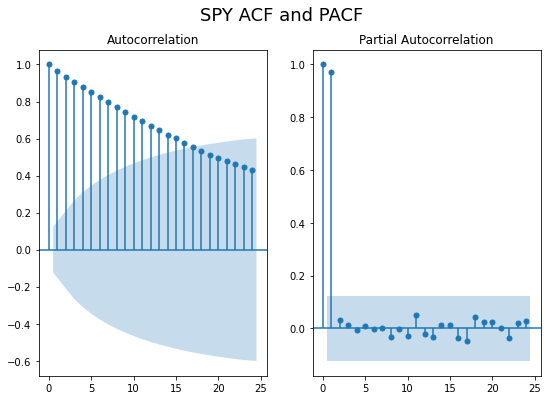

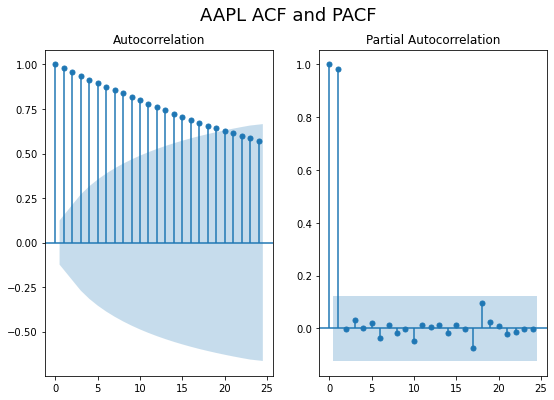

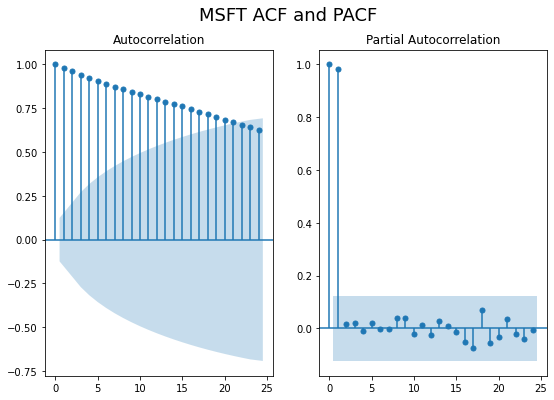

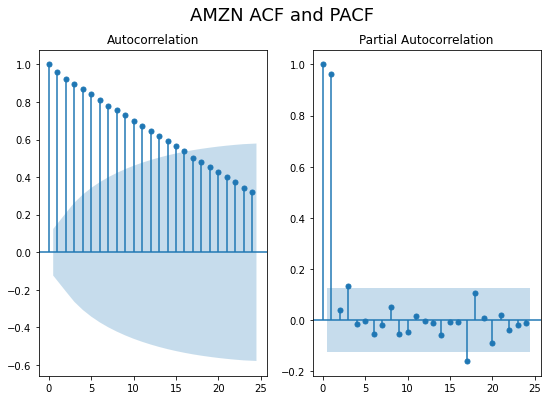

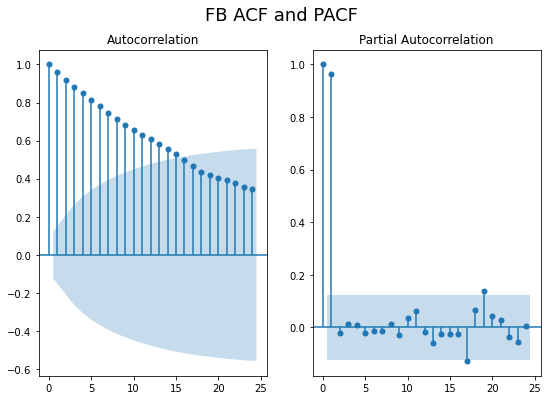

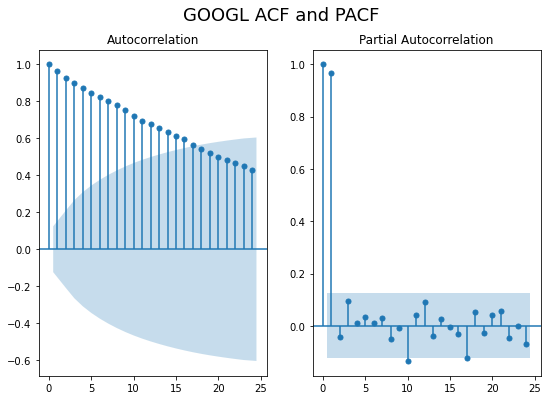

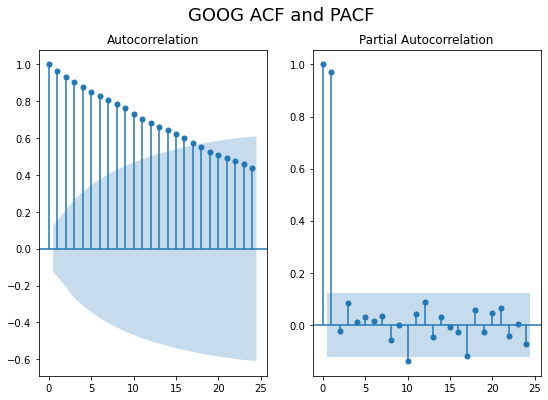

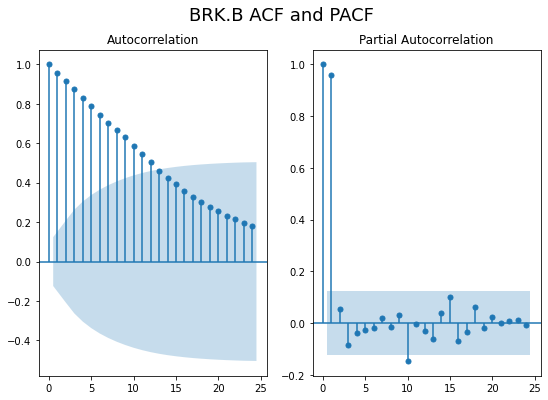

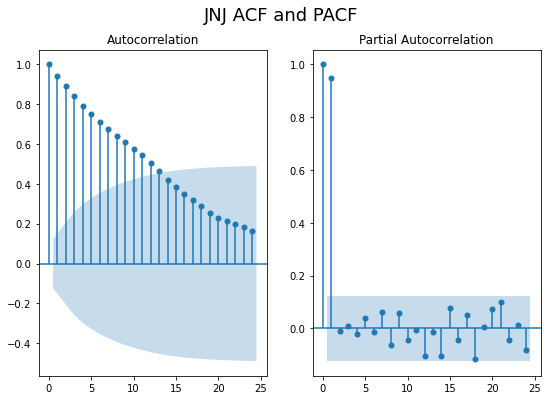

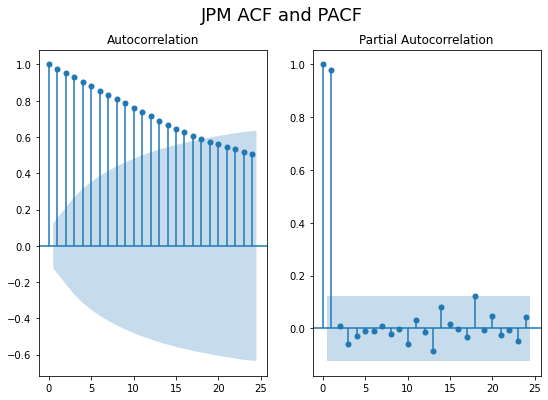

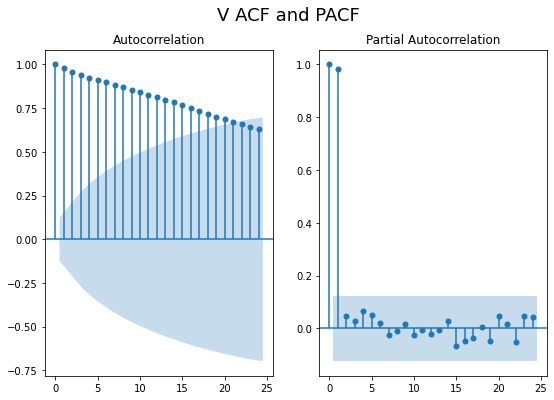

In [91]:
for symbol in symbols:
    filepath = "data/{}_daily01.csv".format(symbol)
    stock_df = pd.read_csv(filepath)
    stock_df = stock_df[(stock_df.to_datetime > analysis_date_start) & (stock_df.to_datetime < analysis_date_end)][pricetype]
    plot_title = "{} ACF and PACF".format(symbol)
    fig, ax = plt.subplots(1,2, figsize=(9,6))
    plot_acf(stock_df.values, ax=ax[0]);
    plot_pacf(stock_df.values, ax=ax[1]);
    fig.suptitle(plot_title, size=18)

## GridSearch on ARIMA for Optimal Model Determination

PACF of all stock data so far provided a starting point of AR order of 2 for ARIMA model. Therefore, the optimal orders of Integration (I) and Moving Average (MA) through gridsearch iteration. The order of I will be between 0 and 1 and the order of MA will be between 1 and 2.

Some results may show that MA order of 0 providing the least amount of prediction error, but providing minimum order of 1 on MA model can reduce the "jumpiness" in the prediction allowing for more steady prediction. 

The gridsearch will be performed on the closing price of the data set on date range set previously and prediction will be made on 30 day range. 

Stock prices on Facebook(FB) will result in LU decomposition error, so the prediction for this model has been done separately.

The optimal values are determined by analyzing the grid search results. Following parameters are used:
- Model converges (TRUE)
- No warning flag present (0)
- Lowest RMSE values 

In [92]:
def ARIMA_gridsearch(p, d_max:int, q_max:int, data, prediction_length):
    return_list = [] #initialize return list
    train_data_idx = len(data) - prediction_length
    train = data[:train_data_idx] #slice train and test data
    test = data[train_data_idx:]
    d_range = range(0, d_max+1)
    q_range = range(1, q_max+1)
    for d in d_range:
        for q in q_range:
            model = ARIMA(train, order=(p,d,q)) #fit and predict
            arima_model = model.fit()
            model_prediction = arima_model.forecast(steps=prediction_length)
            warning = arima_model.mle_retvals["warnflag"]
            convergence = arima_model.mle_retvals["converged"]
            rmse_result = np.sqrt(mean_squared_error(test, model_prediction)) #get rmse
            return_list.append([p,d,q,convergence, warning, rmse_result])
    return sorted(return_list, key=lambda x: (x[-1], x[-2], (x[-3]*-1))) #order by RMSE, no warning, and convergence

In [93]:
symbols=["SPY", "AAPL", "MSFT", "AMZN", "GOOGL", "GOOG", "BRK.B", "JNJ", "JPM", "V"] #big 10 symbols to collect

In [94]:
for symbol in symbols:
    filepath = "data/{}_daily01.csv".format(symbol)
    stock_df = pd.read_csv(filepath)
    stock_df = stock_df[(stock_df.to_datetime > analysis_date_start) & (stock_df.to_datetime < analysis_date_end)][pricetype]
    grid_result = ARIMA_gridsearch(2, 1, 2, stock_df.values, 30)
    print(symbol)
    print(grid_result)

SPY
[[2, 1, 2, False, 1, 6.038896394611608], [2, 1, 1, True, 0, 6.133535265987019], [2, 0, 1, True, 0, 7.910442985875483], [2, 0, 2, True, 0, 7.921973599263843]]
AAPL
[[2, 1, 1, True, 0, 3.0919766317554562], [2, 1, 2, True, 0, 3.16621923639813], [2, 0, 2, False, 1, 3.4324122123853376], [2, 0, 1, True, 0, 3.4861652335507656]]
MSFT
[[2, 1, 1, True, 0, 4.6888787602158795], [2, 1, 2, True, 0, 4.733014898829378], [2, 0, 2, True, 0, 5.5033711568718795], [2, 0, 1, True, 0, 5.6960122293811635]]
AMZN
[[2, 0, 2, True, 0, 43.12244967694975], [2, 0, 1, True, 0, 50.16137764234307], [2, 1, 2, True, 0, 54.70479377414592], [2, 1, 1, True, 0, 54.706774632053815]]
GOOGL
[[2, 1, 1, True, 0, 23.720176724392818], [2, 1, 2, True, 0, 23.94938223485102], [2, 0, 2, True, 0, 49.47363304550478], [2, 0, 1, True, 0, 69.6480674635141]]
GOOG
[[2, 1, 1, True, 0, 22.82116570650031], [2, 1, 2, True, 0, 23.003639194341943], [2, 0, 2, True, 0, 46.68708384612614], [2, 0, 1, True, 0, 67.29297816214624]]
BRK.B
[[2, 1, 2, Tr

#### Facebook GridSearch

In [95]:
filepath = "data/{}_daily01.csv".format("FB")
stock_df = pd.read_csv(filepath)
stock_df = stock_df[(stock_df.to_datetime > analysis_date_start) & (stock_df.to_datetime < analysis_date_end)][pricetype]
grid_result = ARIMA_gridsearch(2, 1, 1, stock_df.values, 30)
print(symbol)
print(grid_result)

V
[[2, 1, 1, True, 0, 7.024736087341886], [2, 0, 1, False, 1, 10.366523855508477]]


Gridsearch Resulted in ARIMA order of 2, 1, 1 to be the most appropriate model for prediction of closing prices for all stocks except for JPM (JPMorgan Chase). For JPM, it was determined that order of 2, 0, 2 was most appropriate. 

### ARIMA Orders for all stocks

All determined ARIMA orders were saved for modeling puproses. 
**NOTE** During prediction it was found that `GOOGL` has LU decomposition error during prediction, requiring a drop in int integration order of 0. 

In [96]:
symbols=["SPY", "AAPL", "MSFT", "AMZN", "FB", "GOOGL", "GOOG", "BRK.B", "JNJ", "V", "JPM"] #big 10 symbols to collect
order_01 = [[2, 1, 1]] * (len(symbols)-1)
order_01.append([2, 0, 2])
ARIMA_orders = dict(zip(symbols, order_01))

In [97]:
ARIMA_orders

{'SPY': [2, 1, 1],
 'AAPL': [2, 1, 1],
 'MSFT': [2, 1, 1],
 'AMZN': [2, 1, 1],
 'FB': [2, 1, 1],
 'GOOGL': [2, 1, 1],
 'GOOG': [2, 1, 1],
 'BRK.B': [2, 1, 1],
 'JNJ': [2, 1, 1],
 'V': [2, 1, 1],
 'JPM': [2, 0, 2]}

In [98]:
# update google
ARIMA_orders["GOOGL"] = [2, 0, 1]

## Model Fitting and Rolling Prediction

The ARIMA order was used to make prediction every 5 days based on pervious 25 days of data. All prediction was aggregated to plot the overall prediction against the true stock prices. 

Working on SPY
Total RMSE Error on SPY Stock Prices
4.189340998262795
Working on AAPL
Total RMSE Error on AAPL Stock Prices
1.4359213104724895
Working on MSFT
Total RMSE Error on MSFT Stock Prices
2.6573012806110827
Working on AMZN
Total RMSE Error on AMZN Stock Prices
43.67443414391565
Working on FB
Total RMSE Error on FB Stock Prices
5.206405050262435
Working on GOOGL
Total RMSE Error on GOOGL Stock Prices
19.248911980217283
Working on GOOG
Total RMSE Error on GOOG Stock Prices
29.137751484673718
Working on BRK.B
Total RMSE Error on BRK.B Stock Prices
3.988987245932038
Working on JNJ
Total RMSE Error on JNJ Stock Prices
3.5211233917458156
Working on V
Total RMSE Error on V Stock Prices
2.6188975629807874
Working on JPM
Total RMSE Error on JPM Stock Prices
1.7451991374392373


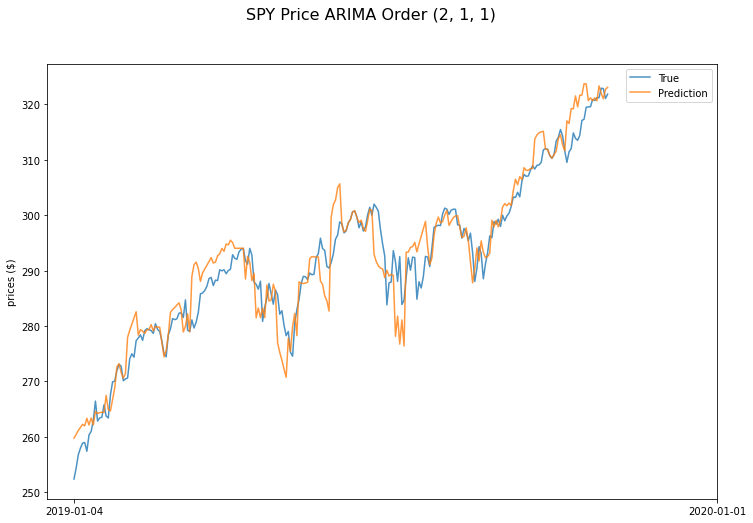

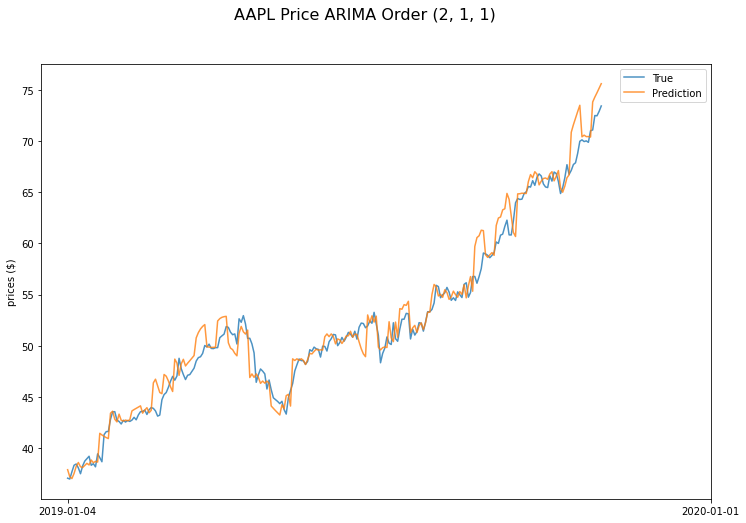

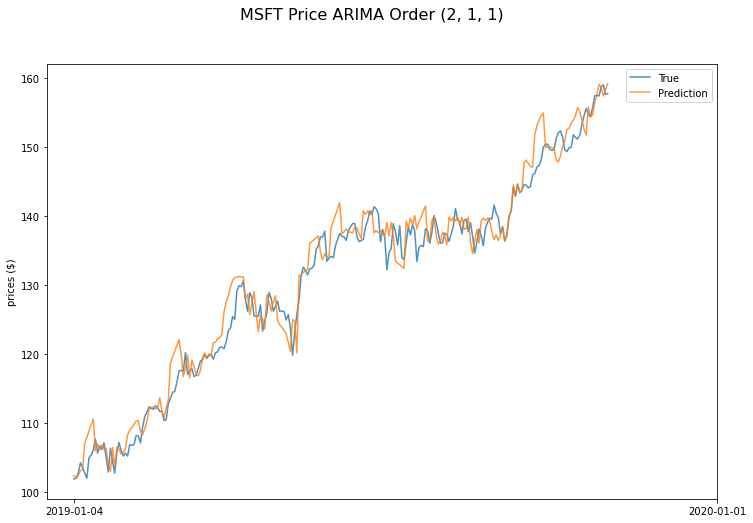

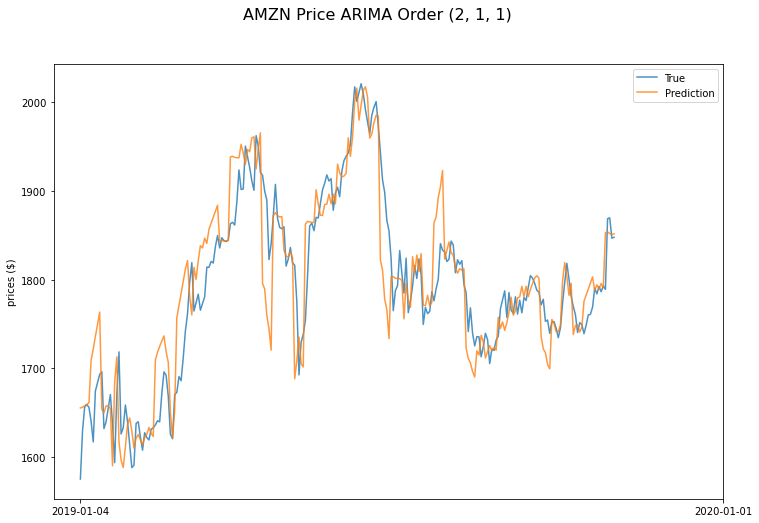

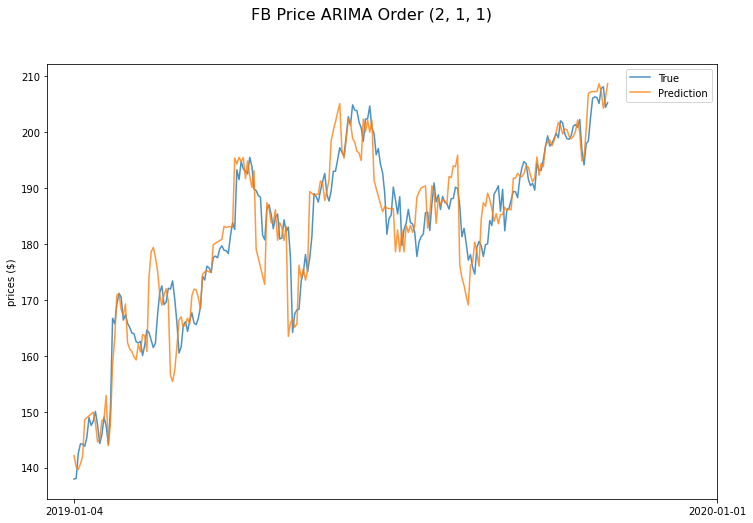

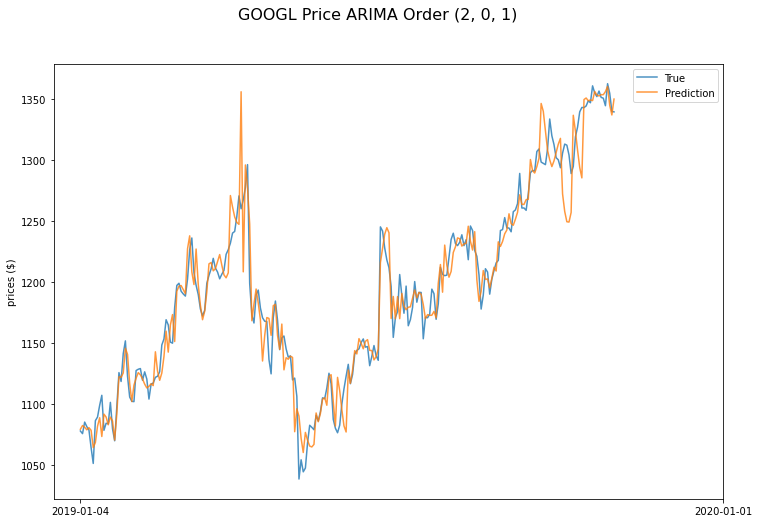

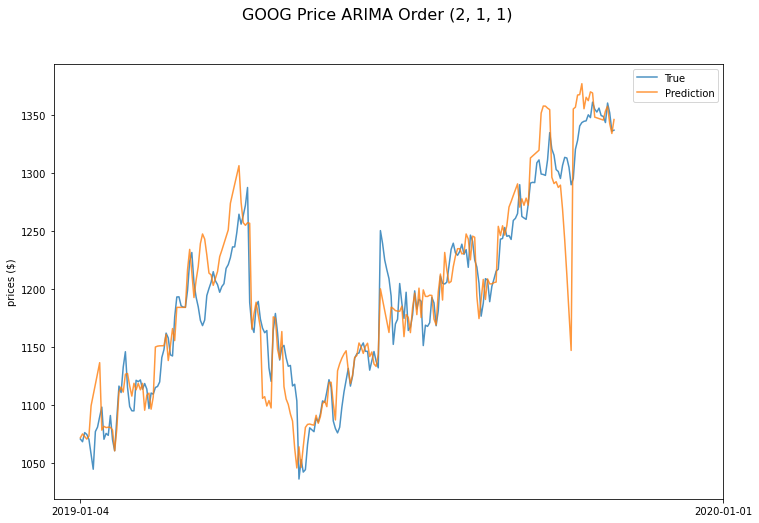

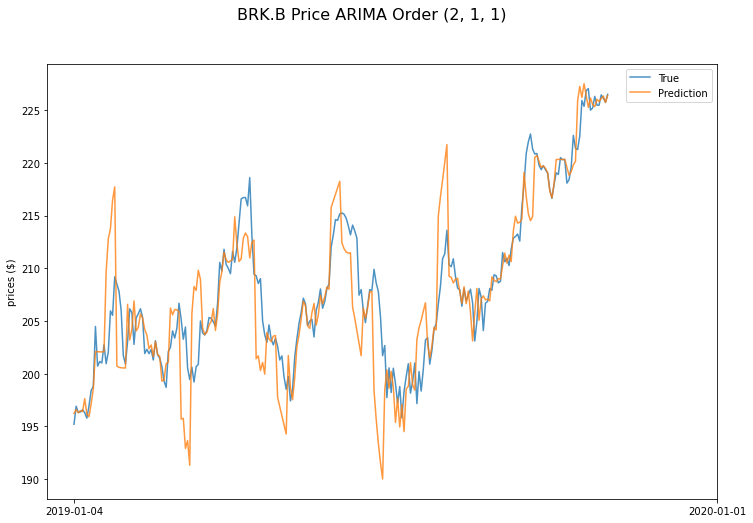

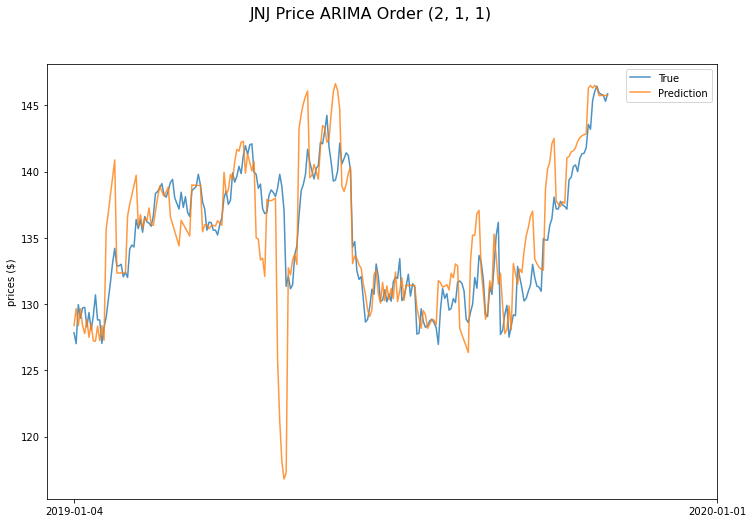

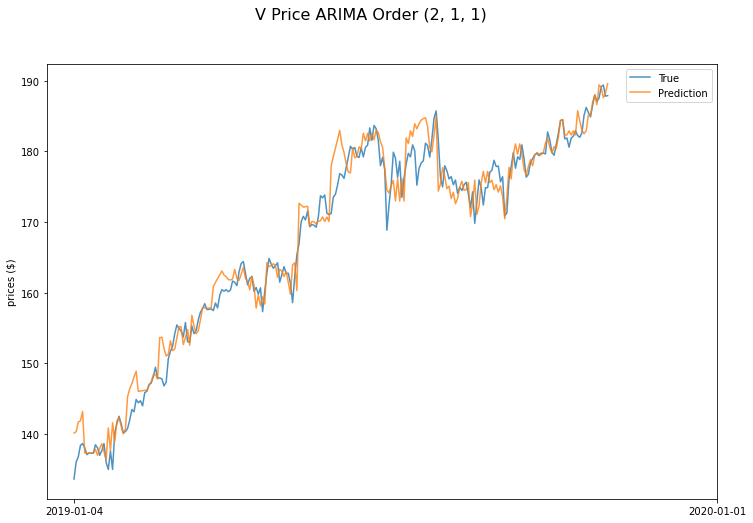

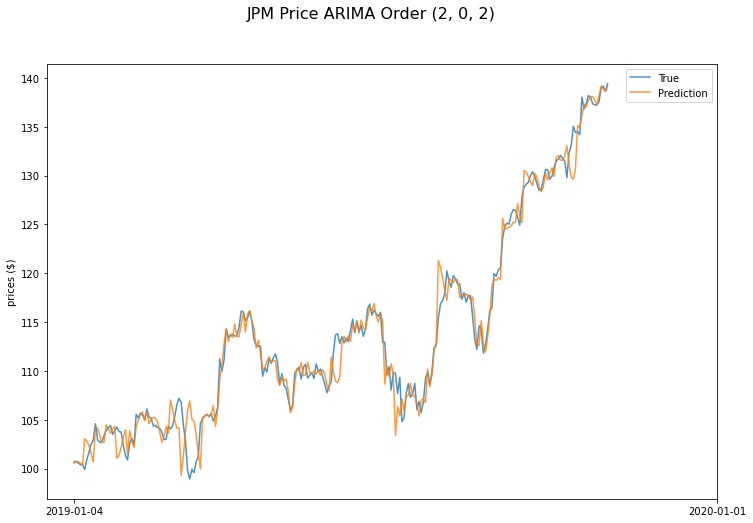

In [130]:
#initialize rmse value storage
rmse_dict = {}

for key, values in ARIMA_orders.items():
    print("Working on {}".format(key))
    # get dataframe for relevant stocks
    filepath = "data/{}_daily01.csv".format(key)
    stock_df = pd.read_csv(filepath)
    stock_df = stock_df[(stock_df.to_datetime > analysis_date_start) & (stock_df.to_datetime < analysis_date_end)][pricetype]
    
    #intialize variables for rolling prediction
    rolling_pred = pd.Series(dtype="float64")
    
    given_length = 25
    prediction_length = 5
    index=0
    p, d, q = values[0], values[1], values[2]
    
    
    while index < len(stock_df): #while loop for rolling prediction
        # slice training data
        index_stop = index + prediction_length
        train_data = stock_df[index:index_stop]
        # fit ARIMA Model per specification
        mod_arma = ARIMA(train_data, order=(p, d, q))
        res_arma = mod_arma.fit()
        #forecast and save data
        prediction = res_arma.forecast(steps=prediction_length)
        rolling_pred = pd.concat([rolling_pred, prediction])
        # keep on rolling
        index += prediction_length
    
    #save model
    model_save_path = f"models/{key}_arima.pickle"
    #res_arma.save(model_save_path) #uncomment to save
    
    #reset indexes for plotting
    rolling_pred = rolling_pred.reset_index().drop(columns="index")
    stock_df = stock_df.reset_index().drop(columns="index")
    
    error = np.sqrt(mean_squared_error(stock_df, rolling_pred[:(stock_df.index[-1]+1)]))
    print("Total RMSE Error on {} Stock Prices".format(key))
    print(error)
    
    #save RMSE
    rmse_dict[key] = error
    
    #plot result
    fig, ax = plt.subplots(figsize=(12,8))
    
    stock = f"{key} Price"
    arima_order = f"ARIMA Order ({p}, {d}, {q})"  

    ax.plot(stock_df[rolling_pred.index[0]:], label="True", alpha=0.8)
    ax.plot(rolling_pred, label="Prediction", alpha=0.8)
    ax.set_ylabel("prices ($)")
    ax.set_xticks([0, 300])
    ax.set_xticklabels([analysis_date_start, analysis_date_end])
    fig.suptitle(" ".join([stock, arima_order]), size = 16)
    plt.legend()
    plt.savefig("images/{}_prediction.png".format(key)) #uncomment to save


## Model Evaluation

In [122]:
#calculate mean

mean_dict = {}
for symbol in symbols:
    filepath = "data/{}_daily01.csv".format(symbol)
    stock_df = pd.read_csv(filepath)
    mean = stock_df[(stock_df.to_datetime > analysis_date_start) & (stock_df.to_datetime < analysis_date_end)][pricetype].mean()
    mean_dict[symbol] = mean
    
mean_df = pd.DataFrame.from_dict(mean_dict, orient="index")
mean_df.columns=["mean"]

In [123]:
rmse_df = pd.DataFrame.from_dict(rmse_dict, orient="index")
rmse_df.columns=["rmse"]
rmse_df = pd.concat([rmse_df, mean_df], axis=1)

In [127]:
rmse_df["percent_error"] = rmse_df["rmse"]/rmse_df["mean"]

In [129]:
rmse_df.sort_values(by="percent_error")

,rmse,mean,percent_error
SPY,4.189341,291.345720,0.014379
JPM,1.745199,113.925040,0.015319
V,2.618898,167.102040,0.015672
GOOGL,19.248912,1192.426060,0.016143
BRK.B,3.988987,208.159240,0.019163
MSFT,2.657301,130.631020,0.020342
AMZN,43.674434,1791.348840,0.024381
GOOG,29.137751,1189.652560,0.024493
JNJ,3.521123,135.000658,0.026082
AAPL,1.435921,52.180385,0.027518


## Conclusion

Overall, all models predicted daily closing prices accurately with %RMSE ranging from 1.5-3% of respective stock prices. Below are the three best performing models, which are S&P500, JPMorgan Chase, and VISA. However, there was some irregularities that significantly impacted this model. On Google class C stock (GOOG) the prediction overshot steep climbs and drops resulting in significant jumps in peaks and valleys. Johnson and Johnson (JNJ) behaved similarly with very promiment jumps between the peaks and the valleys of daily prices. 

Overall, all prediction made in this project yielded more than satisfactory results with all models performing very accurately in the long run. Further work is necessary to stabilize the models sudden drops, especially the inclusion of flash crash due to COVID-19 breakout. This can be tacked by inclusion of seasonality and exogenous variable (SARIMAX) and custom regression model built on neural net with RNN or LSTM layers for inclusion of model "memories".